<!---
layout: post
title: Comparing Network Propagation Methods in Python
tags: 
- Python
- Network Analysis
- igraph
- Networkx
--->

<center> <h1>Comparing Network Propagation Methods in Python</h1> </center>

Network analysis in Python is great because there are a lot of different ways to do it. But choosing which package is easier/faster/better for a given task can be confusing, so it can be useful to occasionally compare alternative methods for a given popular task. In this post, I'll simulate the independent cascade (IC) model using four different network implementations. I first try it with the two most popular Python network packages - `igraph` and `NetworkX` - and then with two "native" approaches that represent a network as a simple Python dictionary or a Pandas dataframe. All methods produce identical propagation processes and are easy to code, but they can differ in terms of speed. Let's get started by loading some packages.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from igraph import *
import networkx as nx
from random import uniform, seed
import numpy as np
import pandas as pd
import time

## General IC Model Outline

We'll first create the general structure of the independent cascade model. The `IC()` function takes as input a `graph_object` which will either be an `igraph` object, a `networkx` object, a Pandas dataframe or a dictionary, depending on which approach we use. Other inputs include the initial list of infected/active "seed nodes" `S` and a propagation probability `p`. Because the independent cascade model is a stochastic process, we calculate the expected spread of a given seed set by taking the average over a large number (`mc`) of Monte Carlo simulations.

The outer loop in the `IC()` function iterates over each of the Monte Carlo simulations and stores the final number of nodes activated from the IC propagation process in the `spread` list. The mean of each of these entries, which is a consistent and unbiased estimator for the expected spread of the nodes contained in `S`, is returned as the first function output.

Within each Monte Carlo iteration, we simulate the spread of influence/disease throughout the network over time, where a different "time period" occurs within each of the `while` loop iterations, which simply checks whether any new nodes were activated in the previous time step. The propagation process  proceeds in three steps. The first step retrieves the out-neighbors of the newly activated nodes. This process differs slightly depending on the type of the `graph_object`, which we check using the `isinstance()` function. We will later write a different `propagate_*()` function for each network representation, but for now just take it as given that each function produces the `targets` list representing the nodes that are "vulnerable" to being activated in this time step.

The second step determines which of the potential `targets` nodes are activated by comparing the activation probability `p` with a uniform random draw. The resulting successfully activated nodes are then extracted from the sorted `targets` list using the `np.extract()` method to create the `new_ones` list. (The `np.random.seed()` function and the sorting of the `targets` list are required to ensure consistency of results when comparing the processes below.) Finally, the third step adds those nodes in `new_ones` to the active set `A` if they are not already included. If no new nodes were activated (`new_active == []` which evaluates to `False`) then the independent cascade process terminates, and the function moves on to the next Monte Carlo simulation. The function also outputs the set of activated nodes `A` from the last Monte Carlo simulation, which is useful to check whether the methods produce identical cascades.

In [5]:
def IC(graph_object,S,p,mc):
    """
    Inputs: graph_object: 4 possible network representations 
                - igraph object
                - Networkx object
                - E x 2 Pandas dataframe of directed edges. Columns: ['source','target']
                - dictionary with key=source node & values=out-neighbors
            S:  List of seed nodes
            p:  Disease propagation probability
            mc: Number of Monte-Carlo simulations,
    Output: Average number of nodes influenced by seed nodes in S
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:
                       
            # 1. Find out-neighbors for each newly active node
            if isinstance(graph_object, Graph):
                targets = propagate_ig(graph_object,p,new_active)
            elif isinstance(graph_object, nx.DiGraph):
                targets = propagate_nx(graph_object,p,new_active)
            elif isinstance(graph_object, dict):
                targets = propagate_dict(graph_object,p,new_active)
            elif isinstance(graph_object, pd.DataFrame):
                targets = propagate_df(graph_object,p,new_active)
    
            # 2. Determine newly activated neighbors (set seed and sort for consistency)
            np.random.seed(i)
            success = np.random.uniform(0,1,len(targets)) < p
            new_ones = list(np.extract(success, sorted(targets)))
            
            # 3. Find newly activated nodes and add to the set of activated nodes
            new_active = list(set(new_ones) - set(A))
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread),A)

We now turn turn to the propagate functions used in step 1 above to extract the set of potential target nodes at each step.

## igraph implementation

The `propagate_ig()` function simply iterates over the set of nodes that were newly activated in the previous time step within the `IC()` function above. For each node, we use the `.neighbors()` method to extract a list of the out-neighbors (by specifying `mode="out"`) and add to the `targets` list, which is the list of candidate nodes susceptible to being activated. Some of these may already be active, but the `IC()` function deals with this in step 3 by only adding nodes that are not already active to the `new_active` list, as explained above.

In [3]:
def propagate_ig(g,p,new_active):
    
    targets = []
    for node in new_active:
        targets += g.neighbors(node,mode="out")
        
    return(targets)

## NetworkX Implementation

The structure (and syntax!) of the `NetworkX` implementation is identical to `propagate_ig()`, apart from not needing to specify the direction of the neighbors. The [NetworkX documentation](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.Graph.neighbors.html) actually doesn't specify that the `.neighbors()` method only gives out-neighbors. So it may be safer to use the `.successors()` method, which is specifically designed for this. Note also that unlike the `igraph` method, `g.neighbors()` actually returns an iterable, not a list. However, this is compatible with the `+=` operator because under the hood it is using the [`.extend()`](https://docs.python.org/3/tutorial/datastructures.html) function.

In [4]:
def propagate_nx(g,p,new_active):
    
    targets = []
    for node in new_active:
        targets += g.neighbors(node)

    return(targets)

## Dictionary Implementation

We now turn away from packages designed specifically for network analysis to more generic Python objects. Here, we represent the network as a native Python dictionary where each key is a source node and each value is a list of the out-neighbors of the corresponding source node. The structure of the function is identical to the above. With this setup, extracting out-neighbors is as simple as making a dictionary call. We use the slightly more robust `.get()` method on the dictionary, which allows us to substitute key-errors for an empty list, as specified by its second argument.

In [6]:
def propagate_dict(g,p,new_active):
    
    targets = []
    for node in new_active:       
        targets += g.get(node,[])
    
    return(targets)

## Dataframe Implementation

Finaly, we represent the network as a Pandas dataframe where each row is a directed edge and the two columns `['source','target']` represent the source node and target node associated with each edge. The structure of the `propagate_df()` function differs slightly from those above. We first restrict the dataframe to consist of those edges/rows where the source is newly active. The susceptible nodes are then simply the resulting `'target'` column in this restricted `temp` dataframe.

In [7]:
def propagate_df(g,p,new_active):
    
    # Restrict dataset to edges that flow out of newly active nodes
    temp = g.loc[g['source'].isin(new_active)]

    # Extract target nodes
    targets = temp['target'].tolist()
    
    return(targets)

## Compare Methods

The last step before implementing our four algorithms is to construct a network. We arbitrarily use a random Erdos-Renyi graph `G`, which we'll first generate with the `igraph` package. The exact type of graph doesn't matter as the main points hold for any graph. To replicate the same graph as a `NetworkX` object, we simply extract the edgelist from `G` to create `g` with the `DiGraph()` function. We then convert the network into a dictionary representation `d` by first constructing lists consisting of each source and target nodes. We then iterate over those lists to set the source nodes as dictionary keys and the target nodes as values. Finally, we construct the dataframe representation `df` by setting the target and source node lists as columns in a Pandas dataframe. We throw all of this into a function for convenience and create network objects with 1000 nodes and 3000 edges.

In [8]:
# Define graph creation function
def make_graph(nodes,edges):
    
    # Generate igraph object
    G = Graph.Erdos_Renyi(n=nodes,m=edges,directed=True)

    # Transform into NetworkX object
    g = nx.DiGraph(G.get_edgelist())

    # Transform into dictionary
    source_nodes = [edge.source for edge in G.es]
    target_nodes = [edge.target for edge in G.es]
    d = {}
    for s, t in zip(source_nodes,target_nodes):
        d[s] = d.get(s,[]) + [t]
        
    # Transform into dataframe
    df = pd.DataFrame({'source': source_nodes,'target': target_nodes})

    return(G, g, d, df)

# Create Graphs
G, g, d, df = make_graph(1000,3000)

We can now try each of our functions and confirm that the resulting cascades are identical for an arbitrarily chosen seed set `S`.

In [13]:
# Choose arbitrary seed set
S = [0,20,33,4]

# Run algorithms
output_ig, A_ig = IC(G,S,p=0.2,mc=100)
output_nx, A_nx = IC(g,S,p=0.2,mc=100)
output_di, A_di = IC(d,S,p=0.2,mc=100)
output_df, A_df = IC(df,S,p=0.2,mc=100)

# Print size of cascade
print("Size of cascade:")
print(output_ig,output_nx,output_di,output_df)

# Print last activated set of nodes
print("\nLast Resulting Cascade:")
print(A_ig); print(A_nx); print(A_di); print(A_df)

Size of cascade:
(28.850000000000001, 28.850000000000001, 28.850000000000001, 28.850000000000001)

Last Resulting Cascade:
[0, 20, 33, 4, 180, 555, 508, 625, 411, 719, 196, 934, 259, 917, 813]
[0, 20, 33, 4, 180, 555, 508, 625, 411, 719, 196, 934, 259, 917, 813]
[0, 20, 33, 4, 180, 555, 508, 625, 411, 719, 196, 934, 259, 917, 813]
[0, 20, 33, 4, 180, 555, 508, 625, 411, 719, 196, 934, 259, 917, 813]


## Speed Comparison by Network Size

We now time each method on a sequence of networks with a fixed number of nodes and an increasing number of edges. This has the effect of increasing the average number of neighbors per node, which increases the size of the `new_active` lists and `for` loops in each of the `propagate_*` functions. We'd therefore expect the computational time to increase, which is confirmed by the plot below.

At small network sizes, the dataframe implementation is the slowest method. This implies that the slicing/filtering procedure on a dataframe, which actually avoids the costly loops required in the other methods, has a large overhead. However, as the network grows, the dataframe overhead is overcome so that it becomes more comparable to the other methods. Interestingly, the `NetworkX` implementation does not seem to scale as well as the other methods, which suggests that accessing a `NetworkX` object is more costly than accessing `igraph` or dictionary objects, given the identical syntax of those methods. Note that increasing the number of Monte-Carlo simulations also increases the computational time of the algorithm, but it does not change the order of the methods because it simply scales the difference between them equally.

In [14]:
# Simulate the processes for different network sizes
e_size = [5000,10000,50000,100000,500000]
ig_time, nx_time, df_time, di_time = [], [], [], []

for edges in e_size:
    
    G, g, d, df = make_graph(5000,edges)
    
    start_time = time.time() 
    _ = IC(G,S,p=0.2,mc=100)
    ig_time.append(time.time() - start_time)

    start_time = time.time() 
    _ = IC(g,S,p=0.2,mc=100)
    nx_time.append(time.time() - start_time)

    start_time = time.time() 
    _ = IC(d,S,p=0.2,mc=100)
    di_time.append(time.time() - start_time)
    
    start_time = time.time() 
    _ = IC(df,S,p=0.2,mc=100)
    df_time.append(time.time() - start_time)

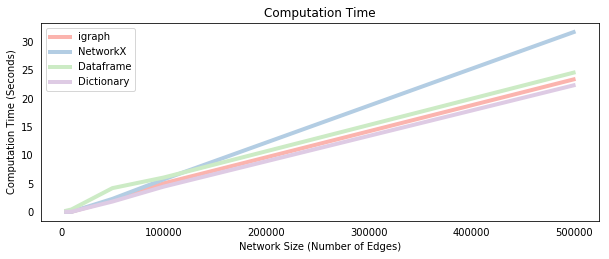

In [15]:
# Plot all methods
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(211)
ax.plot(e_size, ig_time, label="igraph", color="#FBB4AE",lw=4)
ax.plot(e_size, nx_time, label="NetworkX",color="#B3CDE3",lw=4)
ax.plot(e_size, df_time, label="Dataframe",color="#CCEBC5",lw=4)
ax.plot(e_size, di_time, label="Dictionary",color="#DECBE4",lw=4)
ax.legend(loc = 2)
plt.ylabel('Computation Time (Seconds)')
plt.xlabel('Network Size (Number of Edges)')
plt.title('Computation Time')
plt.tick_params(bottom = False, left = False)
plt.show()

## Conclusion

We implemented the independent cascade propagation model using four different approaches - igraph, networkx, dataframe and dictionary.

- Each approach yields identical propagation processes that result in the same infected/activated nodes.
- At small network sizes (meaning low edge/node ratio) the dataframe implementation is slightly slower than the others.
- At larger sizes, the `igraph`, dataframe and dictionary methods were approximately similar whereas the `NetworkX` method doesn't seem to scale as well.

The source code for this post is available at its [Github repository](https://github.com/hautahi/IC_Comparison).